## **MERFISH-Based Spatial Transcriptomics Data Analysis of the Mouse Brain Region**

This notebook implements a step-by-step analysis pipeline for the MERFISH dataset from the study ***Molecular, spatial, and functional single-cell profiling of the hypothalamic preoptic region*** by Moffitt et al. Any MERFISH dataset can be loaded and analyzed similarly.







##  **Environment Setup for SpatialData Installation (Colab)**

SpatialData requires specific versions of `dask` and related packages which may conflict with the default versions in Kaggle or Google Colab. This section ensures the correct environment setup by uninstalling the conflicting packages and installing the required versions.

> **Note**: You will need to **restart the session** after these steps to apply the changes (in Colab: `Runtime` > `Restart session`).


In [1]:
# Step 1: Uninstall conflicting versions of dask-related packages (default versions in Colab/Kaggle)
!pip uninstall -y dask distributed dask-expr rapids-dask-dependency


Found existing installation: dask 2024.12.1
Uninstalling dask-2024.12.1:
  Successfully uninstalled dask-2024.12.1
Found existing installation: distributed 2024.12.1
Uninstalling distributed-2024.12.1:
  Successfully uninstalled distributed-2024.12.1
Found existing installation: dask-expr 1.1.21
Uninstalling dask-expr-1.1.21:
  Successfully uninstalled dask-expr-1.1.21
Found existing installation: rapids-dask-dependency 25.2.0
Uninstalling rapids-dask-dependency-25.2.0:
  Successfully uninstalled rapids-dask-dependency-25.2.0


In [2]:
# Step 2: Install versions compatible with SpatialData
!pip install dask==2024.12.1 distributed==2024.12.1 dask-expr==1.1.21 rapids-dask-dependency==25.2.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.5 MB/s eta 0:00:00


In [ ]:
# Step 3: Restart session

In [1]:
# Step 4: Install SpatialData after setting up the required environment
!pip install spatialdata


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.6 MB/s eta 0:00:00

In [ ]:
# Step 5: Restart session

In [1]:
# Step 6: Check if spatialdata is correctly installed and confirm its version
import spatialdata
print(spatialdata.__version__)


/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


0.4.0


## **Configuration – Set Parameters for Data & Output Paths**

In [2]:
# ====== PARAMETERS / CONFIGURATION ======

# Data download URL (MERFISH dataset)
DATA_URL = "https://s3.embl.de/spatialdata/spatialdata-sandbox/merfish.zip"  # replace with desired URL

# Paths for storing data and outputs
DATA_ZIP_PATH = "/content/merfish.zip"
DATA_UNZIP_DIR = "/content/merfish_unzipped"
ALL_GENES_CSV = "/content/all_genes.csv"
CANDIDATE_GENE_LIST_PATH = "/content/candidate_genes.csv"
GENE_PLOTS_DIR = "/content/gene_plots/"
SCATTER_PLOT_PATH = "/content/scatter_plot.png"
JOINT_EXPR_CSV = "/content/joint_expression_scores.csv"
JOINT_EXPR_PLOT_PATH = "/content/joint_expression_heatmap.png"

# Other parameters
SCATTER_POINT_SIZE = 5
SCATTER_ALPHA = 0.6

# Gene for single gene expression visualization example
EXAMPLE_GENE = "Asic4"
EXAMPLE_GENE_HEATMAP = "/content/gene_plots/Asic4_heatmap.png"


## **Importing Necessary Libraries**

In [3]:
import zipfile
import os
from spatialdata import SpatialData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📁Data Loading

We now download and extract the MERFISH spatial transcriptomics dataset. This dataset captures molecular and spatial information from the mouse hypothalamic preoptic region.


In [4]:
# Step 1: Download the MERFISH dataset archive (already in spatialdata prescribed format)
!wget -O {DATA_ZIP_PATH} {DATA_URL}


--2025-06-09 10:12:29--  https://s3.embl.de/spatialdata/spatialdata-sandbox/merfish.zip
Resolving s3.embl.de (s3.embl.de)... 194.94.45.80
Connecting to s3.embl.de (s3.embl.de)|194.94.45.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53531406 (51M) [application/zip]
Saving to: ‘/content/merfish.zip’

/content/merfish.zi 100%[===================>]  51.05M  14.8MB/s    in 4.5s    

2025-06-09 10:12:35 (11.4 MB/s) - ‘/content/merfish.zip’ saved [53531406/53531406]



In [5]:
# Step 2: Unzip the Dataset


# Create directory if it doesn't exist
os.makedirs(DATA_UNZIP_DIR, exist_ok=True)

# Unzip
with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATA_UNZIP_DIR)

print("Unzipped files:", os.listdir(DATA_UNZIP_DIR))


Unzipped files: ['data.zarr']


In [12]:
# Step 3: Check what is inside extract_path
print("Files and folders inside unzipped folder:")
print(os.listdir(DATA_UNZIP_DIR))


Files and folders inside unzipped folder:
['data.zarr']


In [13]:
# Step 4: As now you know the .zarr folder name exactly (e.g., merfish.zarr or data.zarr), define the path
zarr_path = os.path.join(DATA_UNZIP_DIR, 'data.zarr')  # adjust if folder name is different
print("Zarr folder path:", zarr_path)


Zarr folder path: /content/merfish_unzipped/data.zarr


In [14]:
# Step 5: Read the SpatialData object
sdata = SpatialData.read(zarr_path)
print(sdata)


SpatialData object, with associated Zarr store: /content/merfish_unzipped/data.zarr
├── Images
│     └── 'rasterized': DataArray[cyx] (1, 522, 575)
├── Points
│     └── 'single_molecule': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'anatomical': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'cells': GeoDataFrame shape: (2389, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2389, 268)
with coordinate systems:
    ▸ 'global', with elements:
        rasterized (Images), single_molecule (Points), anatomical (Shapes), cells (Shapes)


/usr/local/lib/python3.11/dist-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


# **Dataset Structure Exploration**

After loading the dataset, we inspect the structure of the `SpatialData` object. This helps us understand the types of spatial and tabular information available, including images, labels, shapes, and cell-level metadata stored in the `AnnData` table.


In [15]:
# View available image keys in the spatial dataset
print("Images:", list(sdata.images.keys()))

# View available label (segmentation or annotation) keys
print("Labels:", list(sdata.labels.keys()))

# View geometric shape annotations if any are present
print("Shapes:", list(sdata.shapes.keys()))

# Confirm the type of the underlying table storing observations
print("Table object type:", type(sdata.table))

# Check the size of the AnnData object (cells × features)
print("AnnData shape:", sdata.table.shape)

# Preview the first few rows of the observations (cell metadata)
print("Table Preview:")
print(sdata.table.obs.head())


Images: ['rasterized']
Labels: []
Shapes: ['anatomical', 'cells']
Table object type: <class 'anndata._core.anndata.AnnData'>
AnnData shape: (2389, 268)
Table Preview:
   cell_id region
0        0  cells
1        1  cells
2        2  cells
3        3  cells
4        4  cells


<ipython-input-15-8563a0376e76>:11: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print("Table object type:", type(sdata.table))
<ipython-input-15-8563a0376e76>:14: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print("AnnData shape:", sdata.table.shape)
<ipython-input-15-8563a0376e76>:18: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  print(sdata.table.obs.head())


# **Essential Dataset Tools**

In the following sections, we extract and save useful metadata from the dataset for external inspection or visualization or even downstream analysis.


## **Save All Gene Names to CSV**  



  Extract all gene names from the spatial transcriptomics dataset and save them in a CSV file. This allows for easy access when performing gene filtering, ranking, or downstream selection.

In [16]:
# Save gene names from the AnnData inside SpatialData
gene_names = sdata.table.var_names.to_list()
gene_df = pd.DataFrame({"gene": gene_names})
gene_df.to_csv(ALL_GENES_CSV, index=False)

print(f"Saved {len(gene_names)} gene names to {ALL_GENES_CSV}")

print('Showing the list of genes:')
print(gene_df)


Saved 268 gene names to /content/all_genes.csv
Showing the list of genes:
              gene
0    1700022I11Rik
1    1810046K07Rik
2    5031425F14Rik
3    5730522E02Rik
4            Acta2
..             ...
263            Vtn
264           Vwc2
265          Wipf3
266          Wnt7b
267        Zfp804b

[268 rows x 1 columns]


<ipython-input-16-5999e926cdd9>:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  gene_names = sdata.table.var_names.to_list()


## **Checking Spatial Geometry and Coordinate Dimensionality**




This code verifies the spatial data’s geometric structure prints the coordinate dimensionality to confirm whether the dataset represents 2D or 3D spatial data.

This check is important for choosing appropriate visualization and analysis methods based on spatial complexity.


In [17]:
# Checking if dataset is 2D or 3D
geometry = sdata.shapes['cells']['geometry']
assert all(geometry.geom_type == 'Point'), "Non-point geometries found!"
coords_dim = geometry.apply(lambda g: len(g.coords[0])).unique()
print(f"Coordinate dimensionality: {coords_dim}")


Coordinate dimensionality: [2]


## **Visualizing Spatial Positions of Cells**

This subsection plots all detected cells (spots) in their spatial coordinates using a scatter plot.  
Each dot represents a single cell’s position within the tissue section.

In [18]:
print("Available tables:", list(sdata.tables.keys()))


Available tables: ['table']


In [19]:
table = sdata.tables['table']  # or replace 'cells' with the right key from the above printout
print(table.obs.columns)

Index(['cell_id', 'region'], dtype='object')


In [20]:
print(sdata.shapes['cells'])

                          geometry     radius
cell_id                                      
0        POINT (1161.113 6178.383)   7.358295
1        POINT (1162.913 6113.133)   8.108447
2        POINT (1168.313 6046.083)   7.667168
3        POINT (1163.813 6202.683)   5.276907
4        POINT (1166.963 6083.883)   7.035876
...                            ...        ...
2384     POINT (3144.263 5201.433)   9.390325
2385     POINT (3154.613 5331.033)   7.980242
2386     POINT (3165.413 5190.183)  10.381395
2387     POINT (3189.713 5292.783)   7.767397
2388     POINT (3196.913 5196.933)   9.594043

[2389 rows x 2 columns]


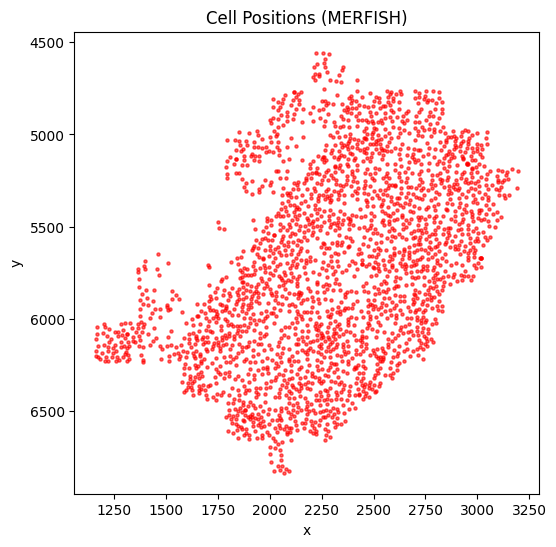

In [21]:
# Extract the geometry column (which contains shapely Points)
geometry = sdata.shapes['cells']['geometry']

# Extract x and y coordinates from each Point
x = geometry.x
y = geometry.y

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=SCATTER_POINT_SIZE, alpha=SCATTER_ALPHA, color='red')
plt.title("Cell Positions (MERFISH)")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().invert_yaxis()  # invert y-axis to match image coordinate system if needed
plt.savefig(SCATTER_PLOT_PATH, dpi=300, bbox_inches='tight')
plt.show()


## **Visualizing Single Gene Expression Heatmap**

This section defines a function to visualize the spatial expression pattern of any selected gene across the tissue section. An example is provided for the gene **“Asic4”**, and the output plot is saved in the folder `/content/gene_plots/`.

In [23]:
def plot_gene_expression_heatmap(sdata, gene_name, output_path=None):
    # Get the AnnData table (assuming there's only one, e.g., 'table')
    table = list(sdata.tables.values())[0]

    # Check if gene exists
    if gene_name not in table.var_names:
        print(f"Gene '{gene_name}' not found in dataset.")
        return

    # Get expression values
    gene_index = table.var_names.get_loc(gene_name)
    X = table.X
    if hasattr(X, "toarray"):  # If sparse, convert to dense
        expression_values = X[:, gene_index].toarray().flatten()
    else:  # Already dense
        expression_values = X[:, gene_index].flatten()

    # Get cell coordinates
    geometry = sdata.shapes['cells']['geometry']
    x = geometry.x
    y = geometry.y

    # Plot
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(x, y, c=expression_values, cmap='viridis', s=9, alpha=0.8)
    plt.colorbar(scatter, label=f"{gene_name} expression")
    plt.title(f"Expression Heatmap: {gene_name}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


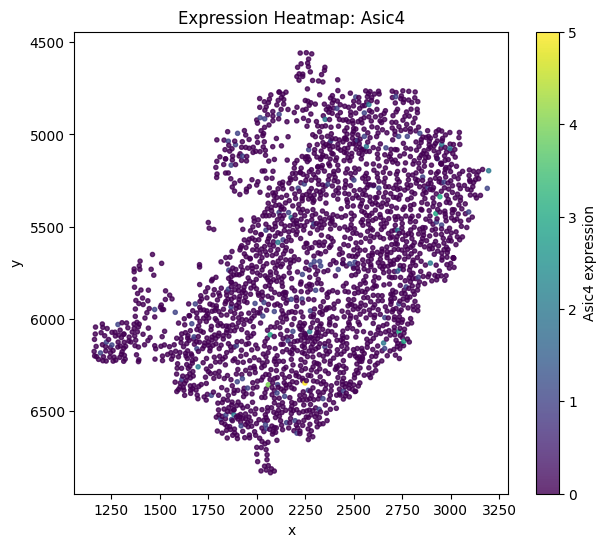

In [25]:
os.makedirs(GENE_PLOTS_DIR, exist_ok=True)
plot_gene_expression_heatmap(sdata, EXAMPLE_GENE, EXAMPLE_GENE_HEATMAP)

## 🔗 **Joint Expression Analysis & Module Score Visualization**

This section performs a combined expression analysis for a set of candidate genes, providing insights into their collective activity across the tissue.

- The candidate genes are loaded from a CSV file (`candidate_genes.csv`), which contains a list of genes of interest.
- The function **`compute_joint_expression`** filters these genes to keep only those present in the dataset.
- It computes a **joint expression score** for each cell by averaging the expression values of the valid candidate genes, representing a module score.
- Spatial coordinates of each cell are extracted from the dataset.
- The joint expression scores, along with the spatial coordinates, are saved to a CSV file for further analysis.
- The function **`plot_joint_expression`** visualizes this combined score as a heatmap across the tissue.
- This approach helps identify spatial patterns of gene modules or pathways, offering biological insights beyond single-gene analysis.

The resulting heatmap plot is saved as `joint_expression_heatmap.png`.


In [27]:
# Load candidate gene list (one gene per line, no header)
candidate_genes = pd.read_csv(CANDIDATE_GENE_LIST_PATH, header=None)[0].tolist()
print(f"Loaded {len(candidate_genes)} genes.")

Loaded 21 genes.


In [28]:
def compute_joint_expression(sdata, gene_list):
    # Get the table (assumes single table)
    table = list(sdata.tables.values())[0]

    # Filter only genes present in the dataset
    valid_genes = [g for g in gene_list if g in table.var_names]
    if not valid_genes:
        raise ValueError("None of the genes are found in the dataset.")
    print(f"{len(valid_genes)} valid genes found in the dataset.")

    # Extract expression matrix and coordinates
    X = table[:, valid_genes].X
    if hasattr(X, "toarray"):
        X = X.toarray()

    joint_score = X.mean(axis=1)  # average expression per cell

    # Coordinates
    geometry = sdata.shapes['cells']['geometry']
    x = geometry.x.values
    y = geometry.y.values

    return pd.DataFrame({"x": x, "y": y, "joint_score": joint_score})


In [29]:
joint_df = compute_joint_expression(sdata, candidate_genes)
joint_df.to_csv(JOINT_EXPR_CSV, index=False)
print("Saved joint scores with coordinates to joint_expression_scores.csv")


21 valid genes found in the dataset.
Saved joint scores with coordinates to joint_expression_scores.csv


In [30]:
def plot_joint_expression(joint_df, title="Joint Expression Heatmap", output_path=None):
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(joint_df["x"], joint_df["y"],
                          c=joint_df["joint_score"], cmap='plasma', s=10, alpha=0.8)
    plt.colorbar(scatter, label="Joint Expression Score")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


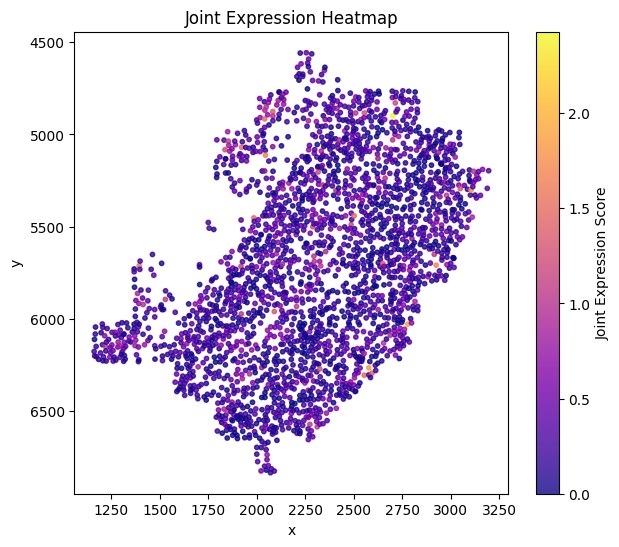

In [31]:
plot_joint_expression(joint_df, output_path=JOINT_EXPR_PLOT_PATH)